## Plotting a NEON RGB Camera Image (Geotif) in Python
This lesson introduces NEON RGB camera images and functions to read in and plot geotif rasters in Python. In this lesson, we will read in an RGB camera tile of the NEON Smithsonian Environmental Research Center (SERC) site, which is used as a teaching example during the 2018 Data Institute. We will run the user-defined functions RGBraster2array and plotRGBimage to read in the image as an array, plot an RGB image of this raster, and plot a histogram of the intensities of one of the three bands. 

### Objectives

In this tutorial, you will gain familiarity running Python through Jupyter Notebook, and you will:

1. Plot a NEON RGB Camera Tile (Data Product 
2. Plot a histogram of a single band of an RGB Camera Tile

### Background

As part of the NEON Airborn Operation Platform's suite of remote sensing instruments, the digital camera producing high-resolution (0.25 m) photographs of the earth’s surface. The camera records light energy that has reflected off the ground in the visible part (red, green and blue) of the light spectrum. Often the camera images are used to provide context for the hyperspectral and LiDAR data. 

https://www.neonscience.org/data-collection/airborne-remote-sensing

**Note:** Don't worry about understanding everything in the raster2array function at this point. If you are curious, we encourage you to read the docstrings, but we will go into more detail during the data institute. 

**Data Tip:** To run a cell you can either select `Cell > Run Cells` with your cursor in the cell you want to run, or use the shortcut key `Shift + Enter`. For more handy shortcuts, refer to the tab `Help > Keyboard Shortcuts`. 

First make sure that you are running the Python 3.5 environment by running the cell below:

In [1]:
import sys
sys.version

'3.5.4 |Anaconda, Inc.| (default, Nov  8 2017, 14:34:30) [MSC v.1900 64 bit (AMD64)]'

You should be running `3.5.x`. If this is not the case, close this console (both the notebook and Home page), and shut down your command prompt that is running your Jupyter notebook. Re-open your command prompt, navigate to your workking directory, and activate your p35 environment by typing `activate p35` in Windows or `source activate p35` in Mac if you followed the pre-institute computer set-up instructions. Once you see `(p35)` at the beginning of your command prompt, you can type `jupyter notebook` to run your notebook.

<p>
<center><strong>Activating `Python 3.5` enviornment from the command prompt</strong></center>
<img src="activate_py35.png" style="width: 300px;"/>
</p>

Now that you are in the right environment, first we will import the gdal package, which contains tools for programming and manipulating the Geospatial Data Abstraction Library (GDAL). For more information on GDAL, please refer to: 

http://www.gdal.org/

In [2]:
import gdal

If you get the following message 

<p>
<center><strong>ModuleNotFoundError</strong></center>
<img src="No_module_named_gdal.png" style="width: 600px;"/>
</p>

**Troubleshooting steps** --> try one of the following:
- from a Jupyter Python cell, run the command:
`!conda install gdal`
- from a Command Prompt (Windows) or Terminal (Mac), activate the appropriate environment

Next we will import the `numpy` and `matplotlib` packages. Numpy stands for **Num**erical **Py**thon This is a standard package that comes with the Anaconda installation of Python, so you should not need to do any additional steps to install it. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
def RGBraster2array(RGB_geotif):
    """RGBraster2array reads in a NEON AOP geotif file and returns 
    a numpy array, and header containing associated metadata with spatial information.
    --------
    Parameters
        RGB_geotif -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    array:
        numpy array of geotif values
    metadata:
        dictionary containing the following metadata (all strings):
            array_rows = # of rows
            array_cols = # of columns
            bands = # of bands
            driver = 
            projection = 
            geotransform = 
            pixelWidth = 
            pixelHeight = 
            ext_dict = dictionary containing spatial extent with keys 'XMin', 'XMax', 'YMin', 'YMax'
            extent = tuple containing spatial extent
            noDataValue = 
            scaleFactor 
    --------
    Example Execution:
    --------
    RGB_geotif = '2017_SERC_2_368000_4306000_image.tif'
    RGBcam_array, RGBcam_metadata = RGBraster2array(RGB_geotif) """
    
    metadata = {}
    dataset = gdal.Open(RGB_geotif)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]
    
    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])
    
    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    for i in range(1, dataset.RasterCount+1):
        band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        band[band==metadata['noDataValue']]=np.nan
        band = band/metadata['scaleFactor']
        array[...,i-1] = band

    return array, metadata

After running this cell, we can call the function, as below. Note that you need to specify the relative path (as shown here with the `./`, indicating that file is saved in your working directory) or the absolute path (eg. `D:\\RSDI_2018\\data`) - you'll need to use double slashes to indicate that you are pointing to a directory. 

In [5]:
RGB_geotif = './2017_SERC_2_368000_4306000_image.tif'
SERC_RGBcam_array, SERC_RGBcam_metadata = RGBraster2array(RGB_geotif)

We can look at the dimensions of this tile by using the `.shape` method:

In [6]:
SERC_RGBcam_array.shape

(10000, 10000, 3)

We can list the metadata information as follows:

In [7]:
#Display information stored in header
for key in sorted(SERC_RGBcam_metadata.keys()):
  print(key)

array_cols
array_rows
bands
driver
ext_dict
extent
geotransform
noDataValue
pixelHeight
pixelWidth
projection
scaleFactor


Next, we'll define a function to plot the array data. Run the cell below:

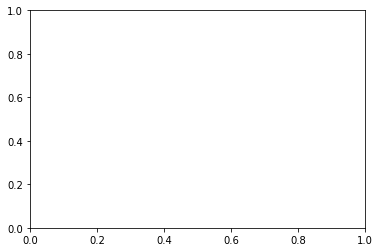

In [8]:
def plot_band_array(band_array,
                    refl_extent,
                    colorlimit,
                    ax=plt.gca(),
                    title='',
                    cbar ='on',
                    cmap_title='',
                    colormap='spectral'):
    
    '''plot_band_array reads in and plots a single band or an rgb band combination of a reflectance array
    --------
    Parameters
    --------
        band_array: flightline array of reflectance values, created from h5refl2array function
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) - use metadata['extent'] from h5refl2array function
        colorlimit: range of values to plot (min,max). Best to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: string, optional; plot title
        cmap_title: string, optional; colorbar title
        colormap: string, optional; see https://matplotlib.org/examples/color/colormaps_reference.html for list of colormaps
    --------
    Returns 
        plots array of single band or RGB if given a 3-band 
    --------
    Example:
    --------
    plot_band_array(SERC_RGBcam_array, 
                    SERC_RGBcam_metadata['extent'],
                    (1,255),
                    title='SERC RGB Camera Tile',
                    cbar='off')'''
    
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

Now run this function using the inputs you defined earlier:

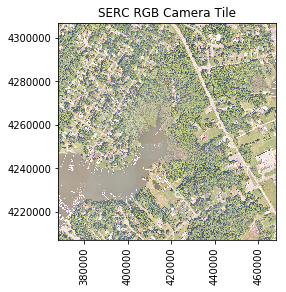

In [9]:
plot_band_array(SERC_RGBcam_array,
                SERC_RGBcam_metadata['extent'],
                (1,255),
                title='SERC RGB Camera Tile',
                cbar='off') 

Lastly, we can plot a histogram of the first band (red), which we can extract by using `splicing`. Since Python is 0-based, to extract all values of the first band, we can use: `SERC_RGBcam_array[:,:,0]`. *Notes*: It speeds up the algorithm to flatten the 2-D array into one dimension using `numpy.ravel`; `20` specifies the number of bins. 

Text(0,0.5,'Frequency')

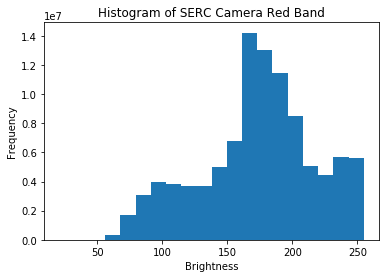

In [10]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,0]),20);
plt.title('Histogram of SERC Camera Red Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

## Exercises: 
Now that you've followed along to read in and plot an RGB camera image and band, try the following exercises on your own:

1. **Plot histograms of the green and blue bands**

2. **Explore the data** to see what you can learn about the `SERC_RGBcam_array` and associated `SERC_RGBcam_metadata` 

    a. Determine the minimum and maximum reflectance for each band. Print these values with a print statement. *HINT*: Use the `numpy` functions `np.amin()` and `np.amax()`
    
    b. What UTM zone is this data in? *HINT: Print out* `SERC_RGBcam_metadata['projection']`
    
    c. Use the `plot_band_array` function to plot each band of the camera image separately. *HINT*: Use splicing to extract each band (eg. `SERC_RGBcam_array[:,:,0]`). 